In [1]:
import os
import glob
import numpy as np
import pandas as pd
import sys
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sns
from scipy import stats

In [2]:
# define the paths to results

data_path  = 'Results/*'

# get results' file paths

file_path_list  = glob.glob(data_path)

# split file names

file_names = [file_path.split('/')[1] for file_path in file_path_list]


In [17]:

# clear models with error

valid_models_path = [ data_path.split('*')[0] + file_name for file_name in file_names 
                                            if file_name.split('__')[0] != 'Error']

print('Number of models studied: {}'.format(len(file_names)))
print('Number of valid models: {}'.format(len(valid_models_path)))

# creating dictionary for model exploration

results_ditc = {}

n_elements = len(valid_models_path)

for results in valid_models_path:

    #Loading results

    name_it = results.split('/')[1]

    it = name_it.split('__')[-3]

    results_ditc[it] = {}

    results_ditc[it]['data'] = []

for i,results in enumerate(valid_models_path):

    #Loading results

    name_it = results.split('/')[1]

    it = name_it.split('__')[-3]

    results_ditc[it]['data'].append(pd.read_csv(results))

    #Updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()
    


Number of models studied: 1386
Number of valid models: 693
[----------------------------------------------------------------------------------------------------] 100.00% - 693 of 693

In [20]:
Class = []
y = np.zeros(30000)
y[-300:] = 1
valid_columns = [
    "px1.1","py1.1","pz1.1","E1.1","eta1.1",
    "phi1.1","pt1.1","px2.1","py2.1","pz2.1",
    "E2.1","eta2.1","phi2.1","pt2.1","Delta_R.1",
    "M12.1","MET.1","S.1","C.1","HT.1","A.1"
]

for it in results_ditc.keys():

    results_ditc[it]['error_ks'] = {}

    results_ditc[it]['mse_ks'] = {}

    results_ditc[it]['mse'] = {}

    for i,df in zip(valid_columns, results_ditc[it]['data']):

        results_ditc[it]['error_ks'][i] = {}

        mse = []

        for col in valid_columns:

            error = df[::][col].values

            mse.append(error)

            signal_error = error[y==1]

            background_error = error[y==0]

            results_ditc[it]['error_ks'][i][col] = stats.ks_2samp(signal_error, 
                                                                    background_error).pvalue


        mse = np.mean(mse,axis=0)

        signal_error = mse[y==1]

        background_error = mse[y==0]

        results_ditc[it]['mse_ks'][i] = stats.ks_2samp(signal_error, 
                                                        background_error).pvalue
        
        results_ditc[it]['mse'][i] = mse


(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(30000,)
(

In [21]:
format_dict = {}

for it in results_ditc.keys():

    for dcorr in results_ditc[it]['error_ks']:

        format_dict[dcorr] = {}

        format_dict[dcorr]['erro_ks'] = {}

        format_dict[dcorr]['mse_ks'] = []

        format_dict[dcorr]['mse'] = []

        for col in results_ditc[it]['error_ks'][dcorr]:

            format_dict[dcorr]['erro_ks'][col] = []

for it in results_ditc.keys():

    for dcorr in results_ditc[it]['error_ks']:

        format_dict[dcorr]['mse_ks'].append(results_ditc[it]['mse_ks'][dcorr])

        format_dict[dcorr]['mse'].append(results_ditc[it]['mse'][dcorr])

        for col in results_ditc[it]['error_ks'][dcorr]:

            format_dict[dcorr]['erro_ks'][col].append(results_ditc[it]['error_ks'][dcorr][col])

error_ks = []

for dcorr in format_dict:
    
    mean = np.mean(format_dict[dcorr]['mse_ks']) 

    std = np.std(format_dict[dcorr]['mse_ks']) 

    format_dict[dcorr]['mse_ks'] = {}

    format_dict[dcorr]['mse_ks']['mean'] = mean

    format_dict[dcorr]['mse_ks']['std'] = std

    error_ks.append(mean)

    mean = np.mean(format_dict[dcorr]['mse'],axis=0) 

    std = np.std(format_dict[dcorr]['mse']) 

    format_dict[dcorr]['mse'] = {}

    format_dict[dcorr]['mse']['mean'] = mean

    format_dict[dcorr]['mse']['std'] = std

    for col in format_dict[dcorr]['erro_ks']:

        mean = np.mean(format_dict[dcorr]['erro_ks'][col]) 

        std = np.std(format_dict[dcorr]['erro_ks'][col]) 

        format_dict[dcorr]['erro_ks'][col] = {}

        format_dict[dcorr]['erro_ks'][col]['mean'] = mean

        format_dict[dcorr]['erro_ks'][col]['std'] = std


(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)
(33, 30000)


In [ ]:

del results_ditc

/home/thiago/yes/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


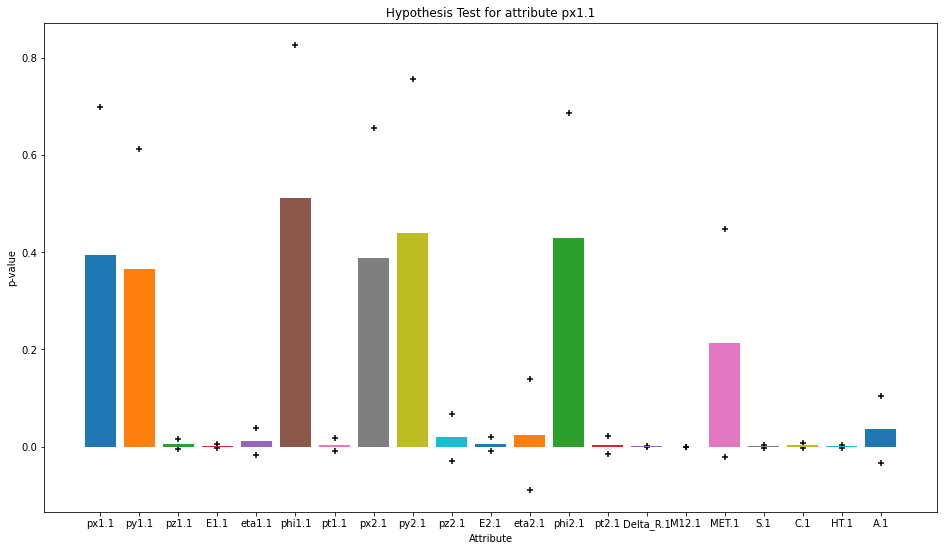

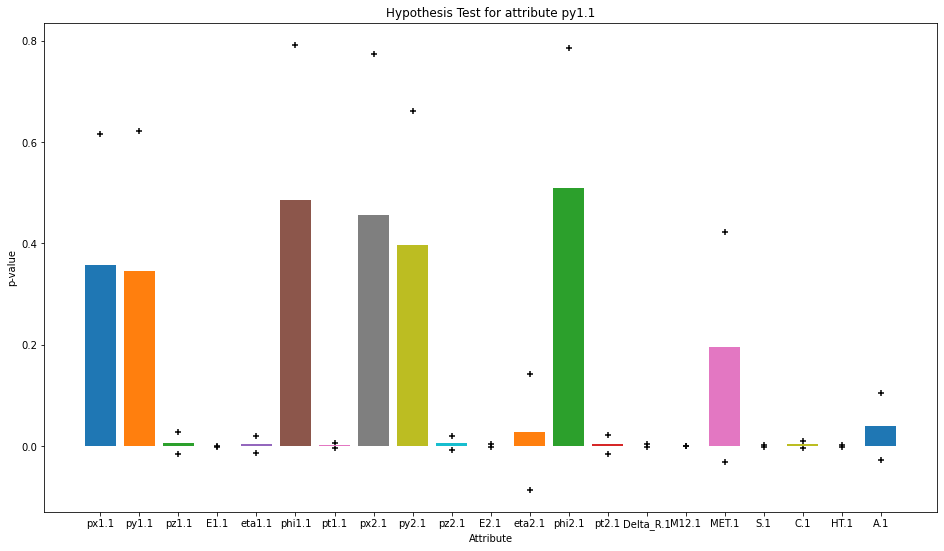

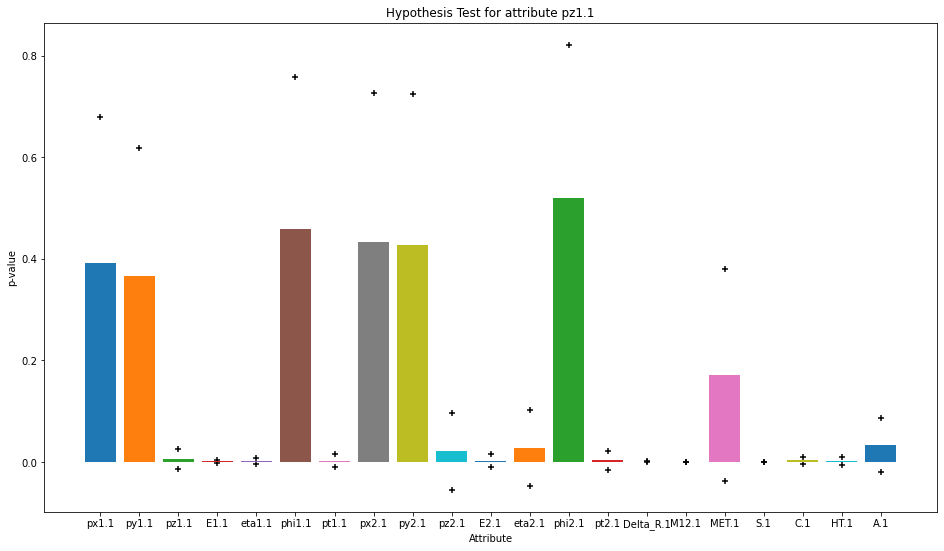

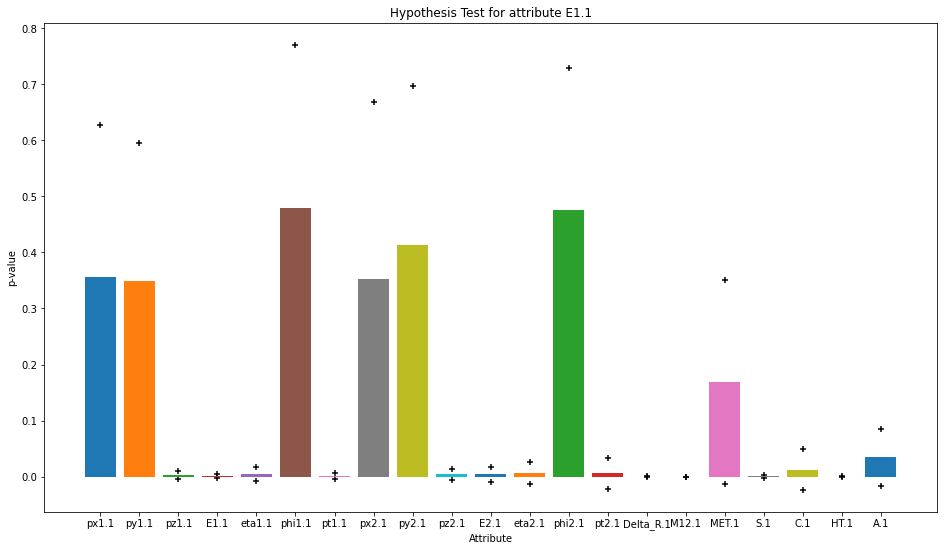

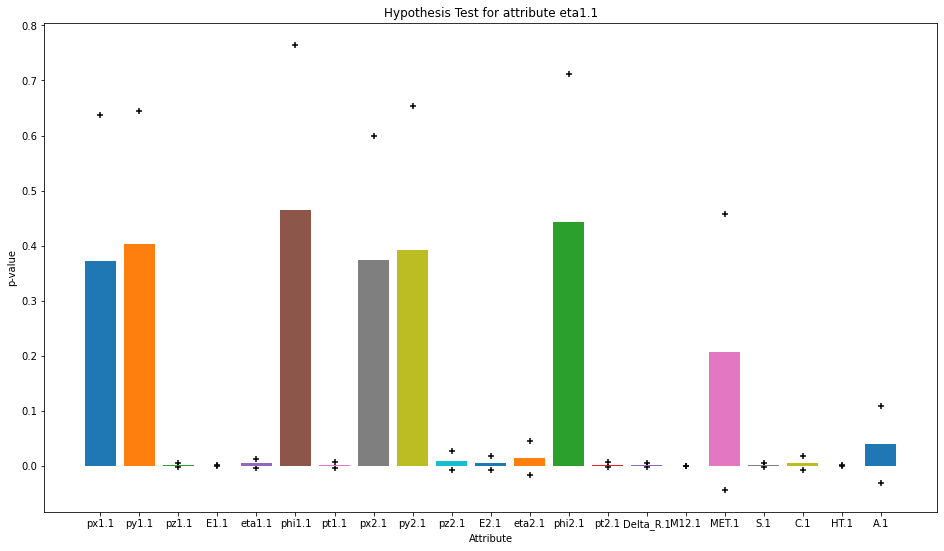

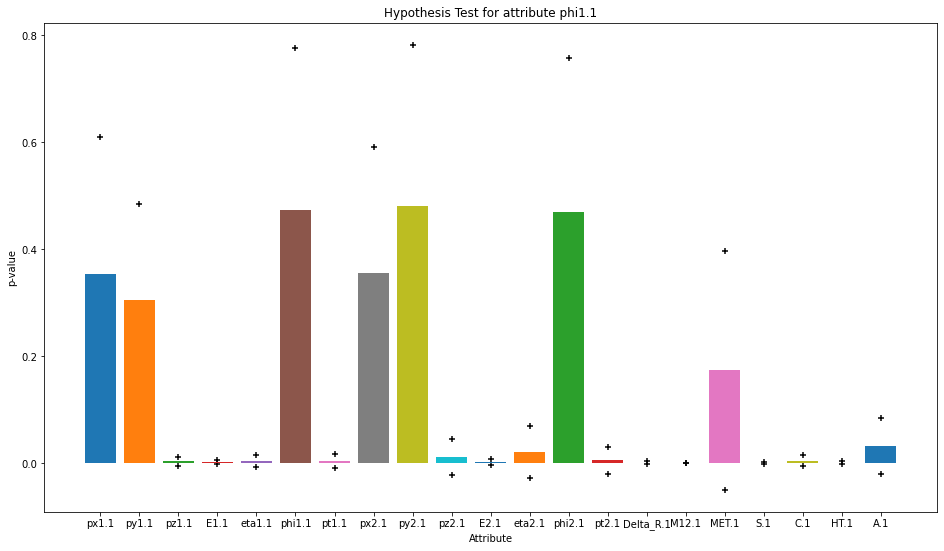

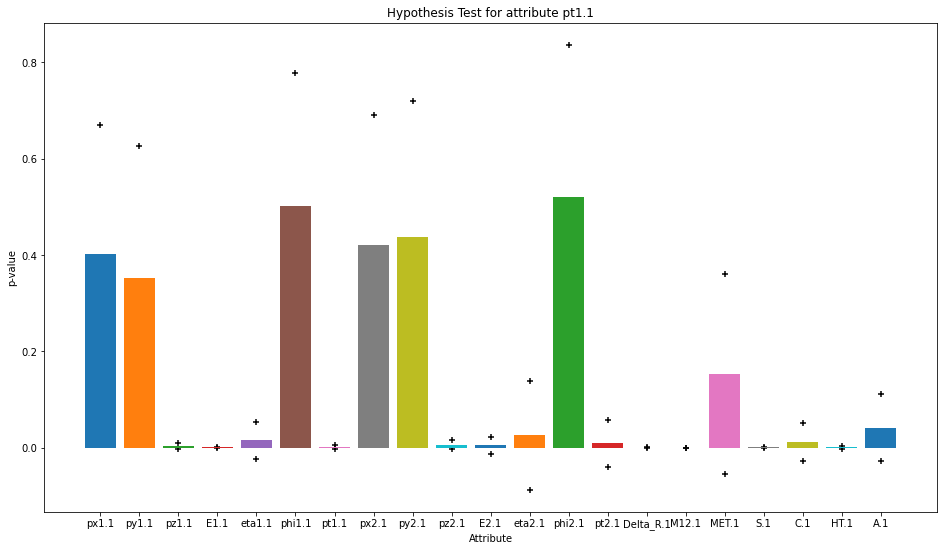

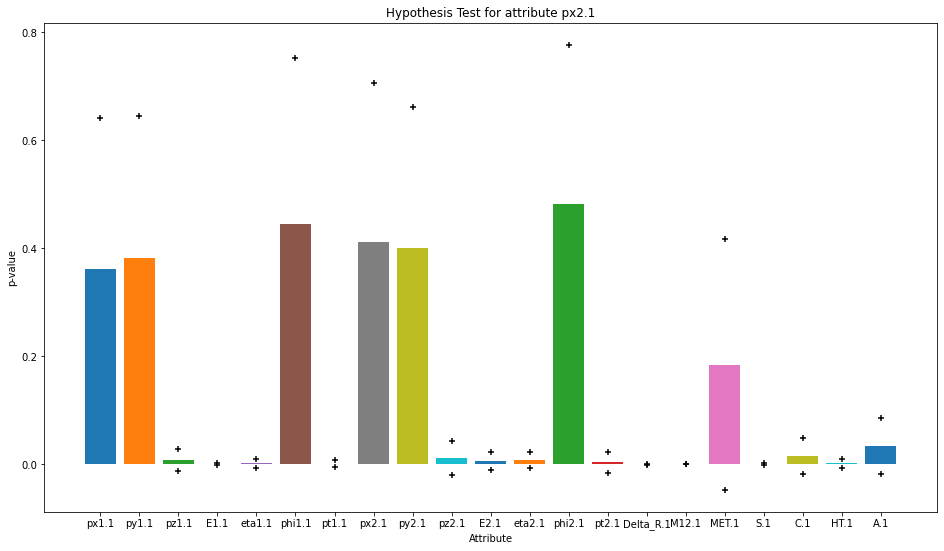

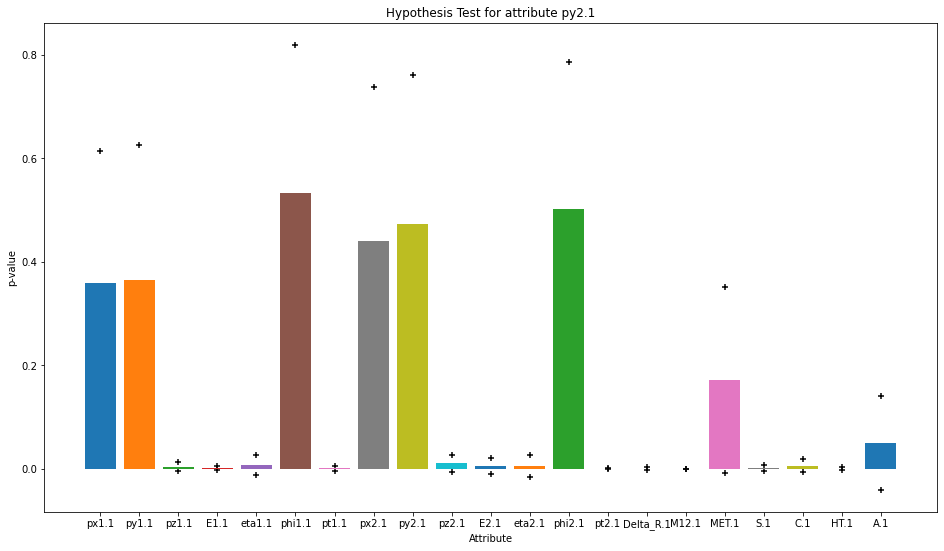

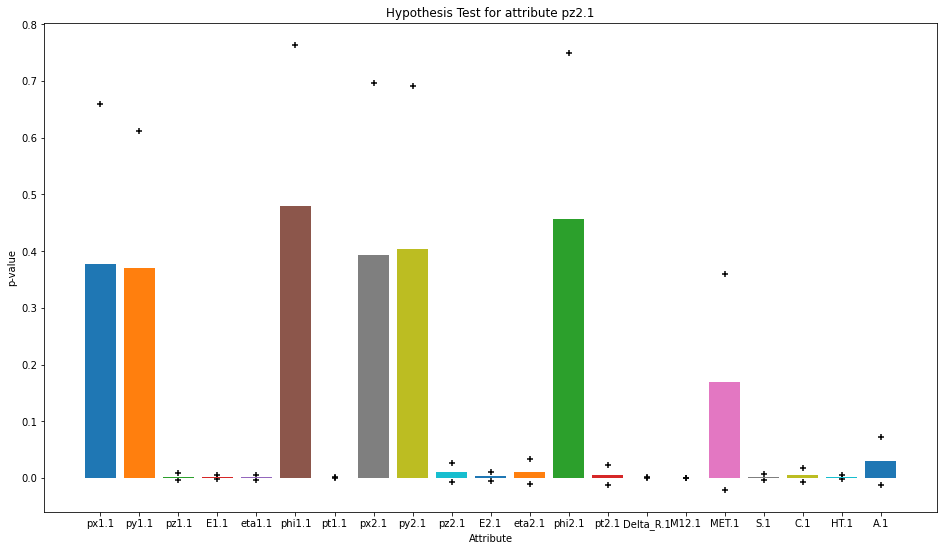

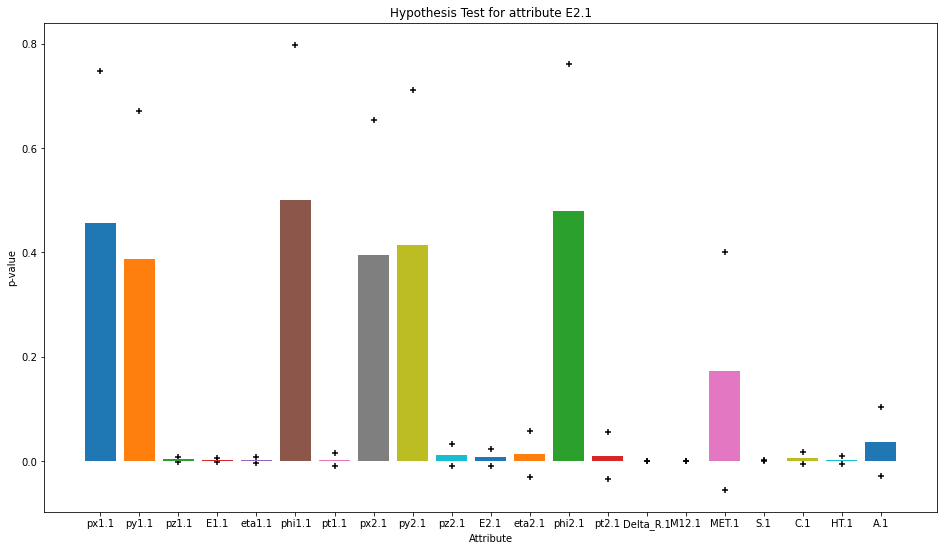

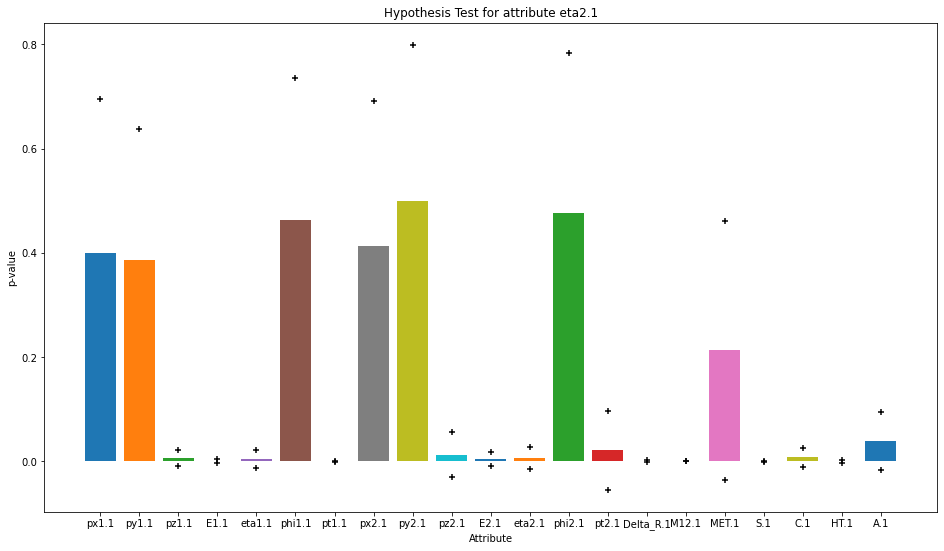

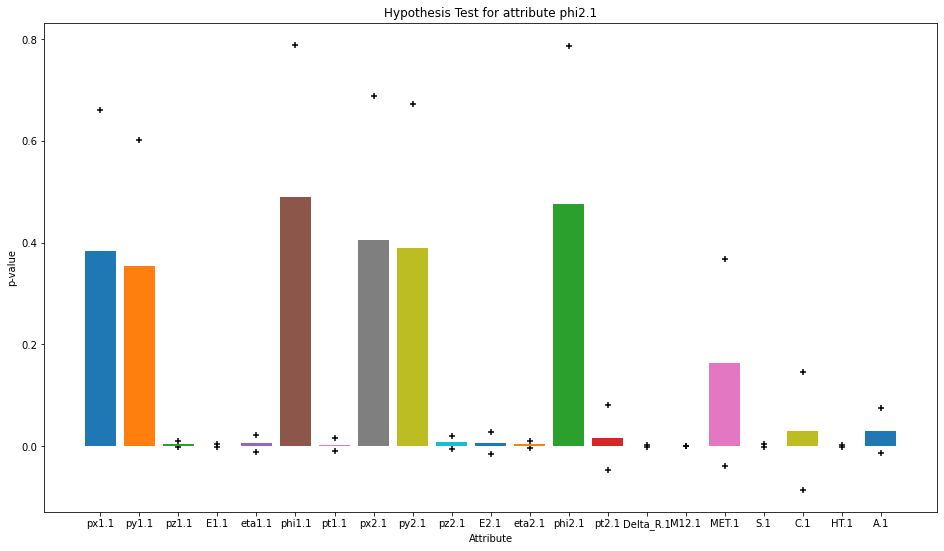

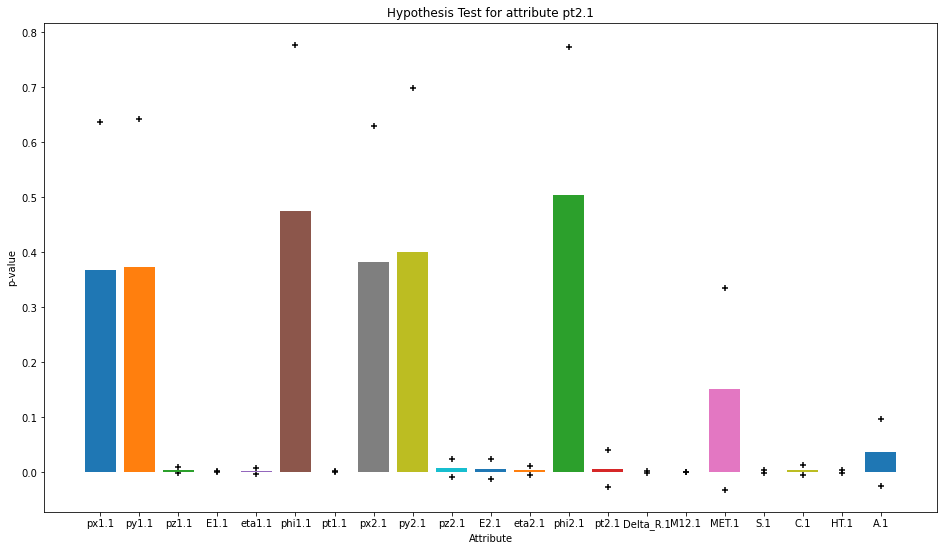

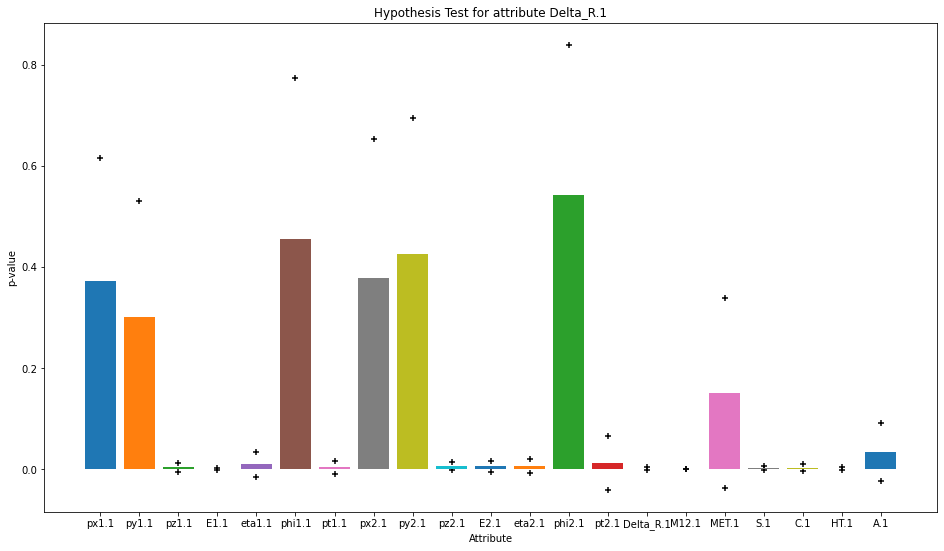

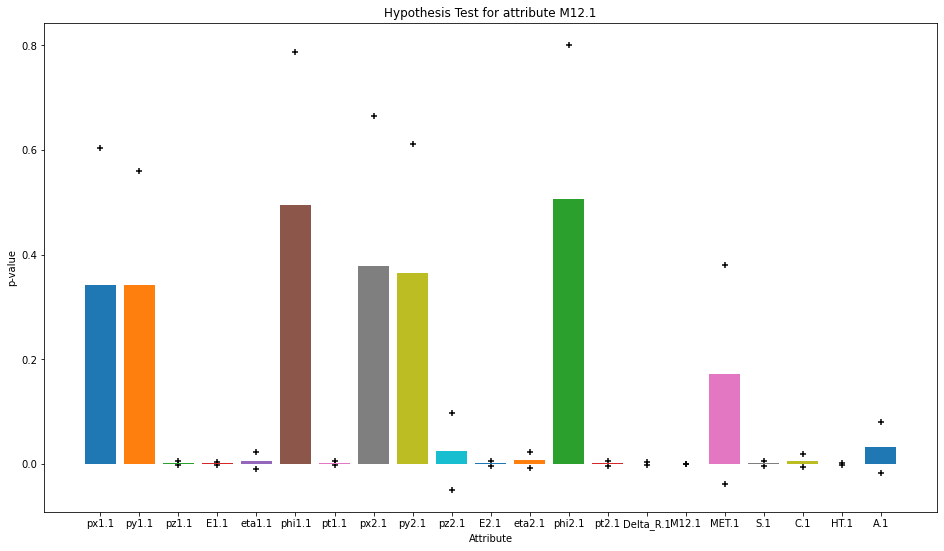

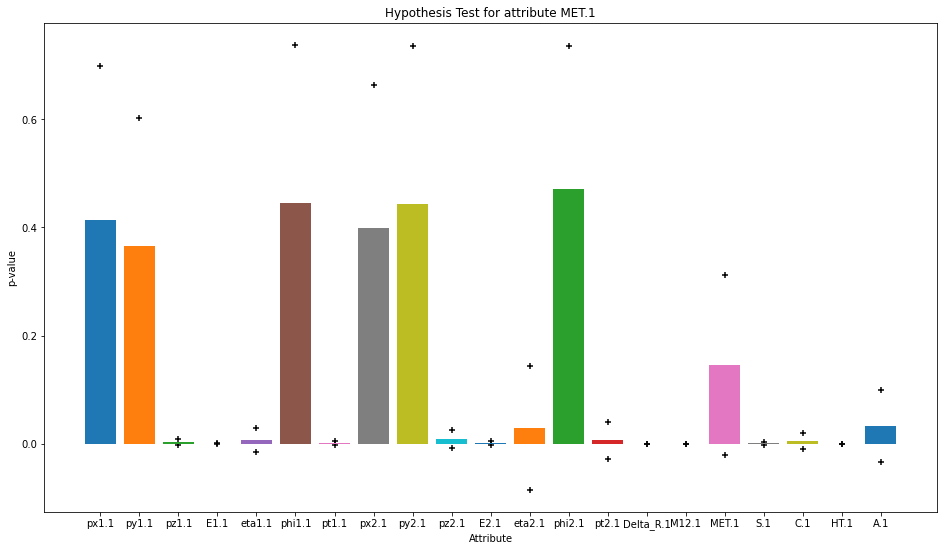

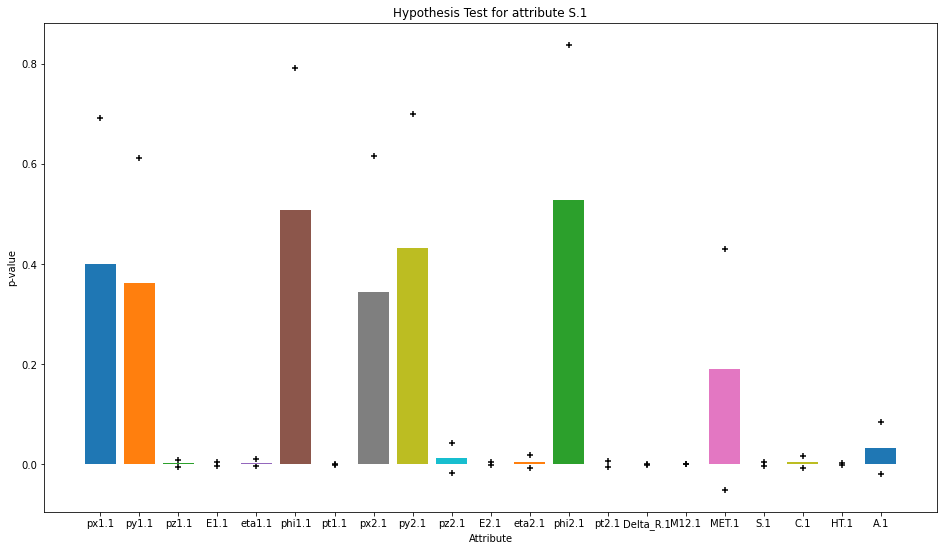

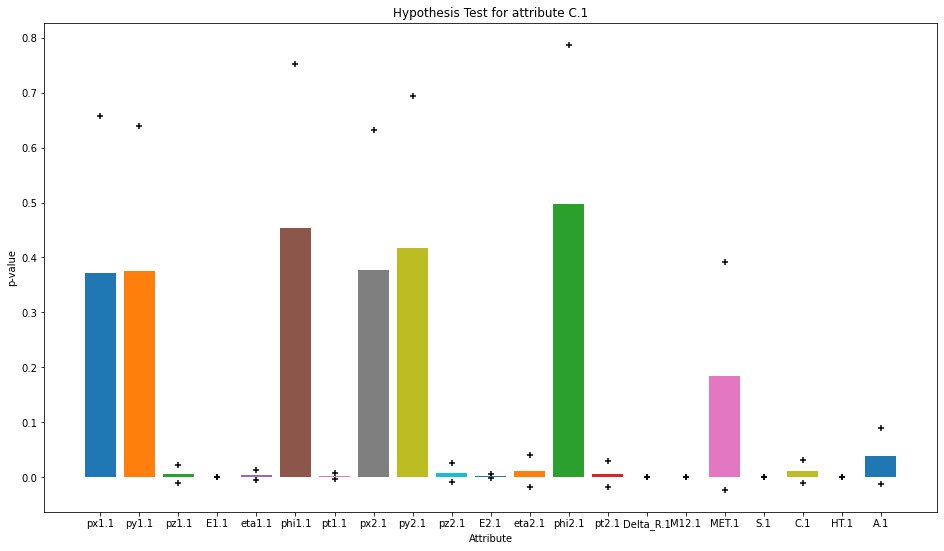

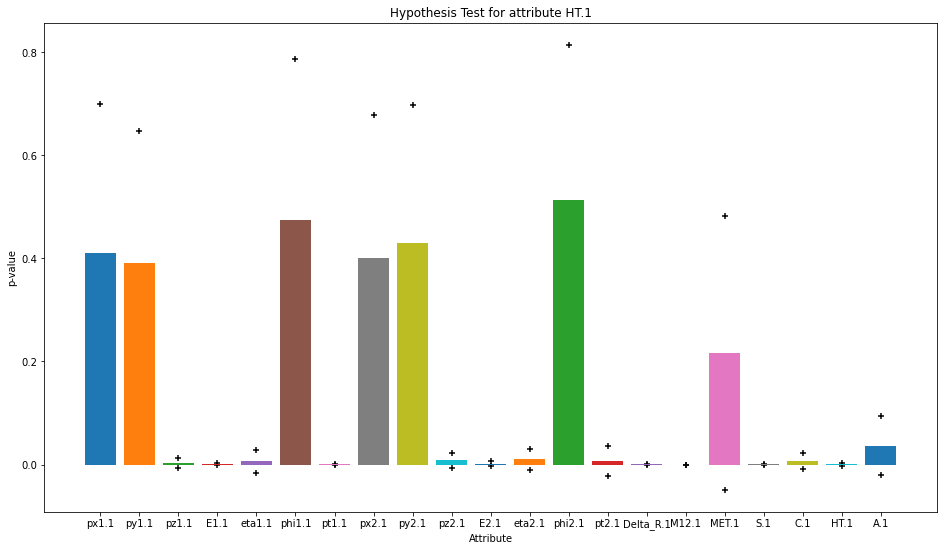

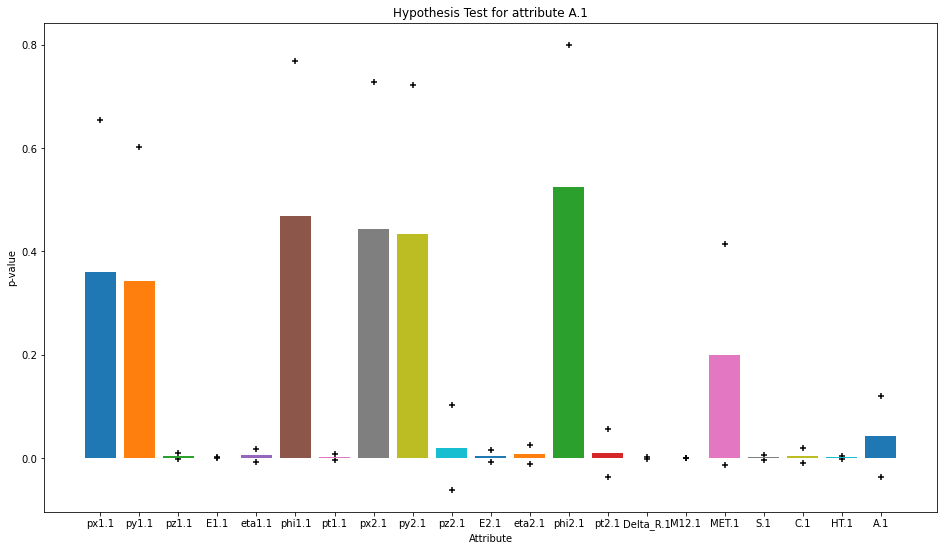

In [6]:
for dcorr in format_dict:

    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    
    for x,col in enumerate(format_dict[dcorr]['erro_ks']):

        mean = format_dict[dcorr]['erro_ks'][col]['mean'] 

        std = format_dict[dcorr]['erro_ks'][col]['std'] 

        ax.bar(col , mean)
        ax.scatter(col , mean+std, c='k', marker='+')
        ax.scatter(col , mean-std, c='k', marker='+')

    plt.title("Hypothesis Test for attribute {}".format(dcorr))
    plt.ylabel("p-value")
    plt.xlabel("Attribute")

    fig.savefig('Figures/reconstruction-error__' + dcorr + '.png', 
                bbox_inches='tight'
            )

In [22]:
sorted_index = np.argsort(error_ks)

sort_error_difference = [error_ks[i] for i in sorted_index]

model_names = [name for name in format_dict.keys()]

sort_model_names = [model_names[i] for i in sorted_index]

small_model_names = sort_model_names[:10]

error_df = pd.DataFrame(np.transpose(sort_error_difference[:10]),index=small_model_names)

display(error_df)


,0
eta2.1,0.024515
py1.1,0.043193
px2.1,0.046181
E2.1,0.050548
pt2.1,0.053658
phi2.1,0.053915
eta1.1,0.054358
MET.1,0.068481
Delta_R.1,0.069866
pt1.1,0.070354


In [23]:
best_model_df = format_dict[sort_model_names[0]]
error_class = pd.DataFrame({'Reconstruction_error': best_model_df['mse']['mean'],
                        'True_class': y})

error_class                  

,Reconstruction_error,True_class
0,0.299025,0.0
1,0.296370,0.0
2,0.284417,0.0
3,0.304701,0.0
4,0.297688,0.0
...,...,...
29995,0.289866,1.0
29996,0.300660,1.0
29997,0.299867,1.0
29998,0.295989,1.0


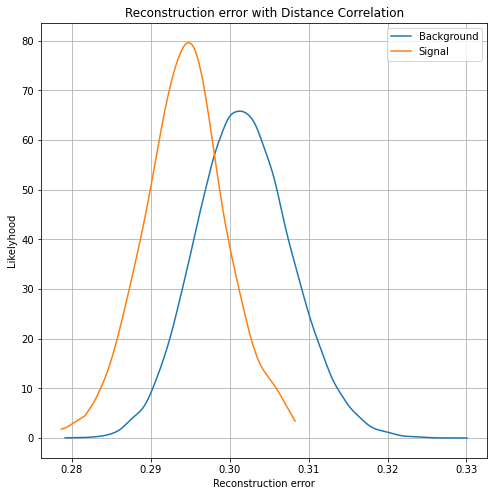

In [24]:

threshold_fixed = 0.12
groups = error_class.groupby('True_class')

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

for name, group in groups:

    kernel = stats.gaussian_kde(group.Reconstruction_error)

    if name == 0:
        labels = "Background"
    
    else:
        labels = "Signal"


    ax.plot(np.sort(group.Reconstruction_error), kernel(np.sort(group.Reconstruction_error)), 
            ms=3.5, linestyle='-',
            label= labels)

ax.legend()
ax.set_title("Reconstruction error with Distance Correlation")
ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Likelyhood")
ax.grid()

plt.show()


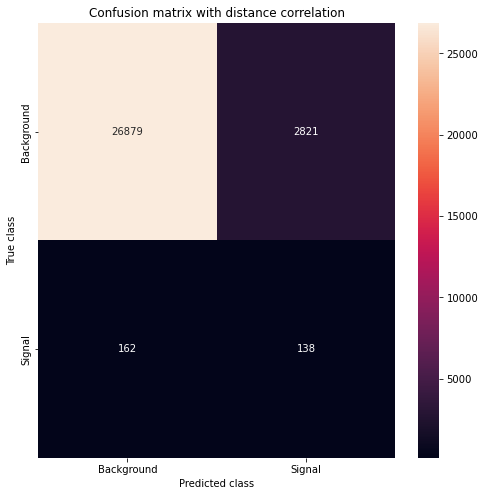

 Accuracy:  0.9005666666666666
 Recall:  0.46
 Precision:  0.04663737749239608


In [33]:
LABELS = ['Background','Signal']

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

# with DisCo

threshold_fixed = 0.29405

pred_y = [1 if e < threshold_fixed else 0 for e in error_class.Reconstruction_error.values]
error_class['pred'] = pred_y
conf_matrix = confusion_matrix(error_class.True_class, pred_y)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
ax.set_title("Confusion matrix with distance correlation")
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

plt.show()

# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_class['True_class'], error_class['pred']))
print(" Recall: ",recall_score(error_class['True_class'], error_class['pred']))
print(" Precision: ",precision_score(error_class['True_class'], error_class['pred']))


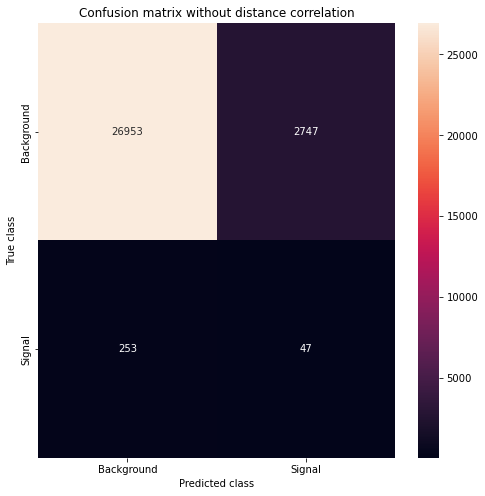

normal Accuracy:  0.9
normal Recall:  0.15666666666666668
normal Precision:  0.016821760916249106


In [68]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

# without DisCo

threshold_fixed = 0.209988

pred_y = [1 if e > threshold_fixed else 0 for e in n_error_class.Reconstruction_error.values]
n_error_class['pred'] = pred_y
conf_matrix = confusion_matrix(n_error_class.True_class, pred_y)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
ax.set_title("Confusion matrix without distance correlation")
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')


plt.show()


# print Accuracy, precision and recall
print("normal Accuracy: ",accuracy_score(n_error_class['True_class'], n_error_class['pred']))
print("normal Recall: ",recall_score(n_error_class['True_class'], n_error_class['pred']))
print("normal Precision: ",precision_score(n_error_class['True_class'], n_error_class['pred']))

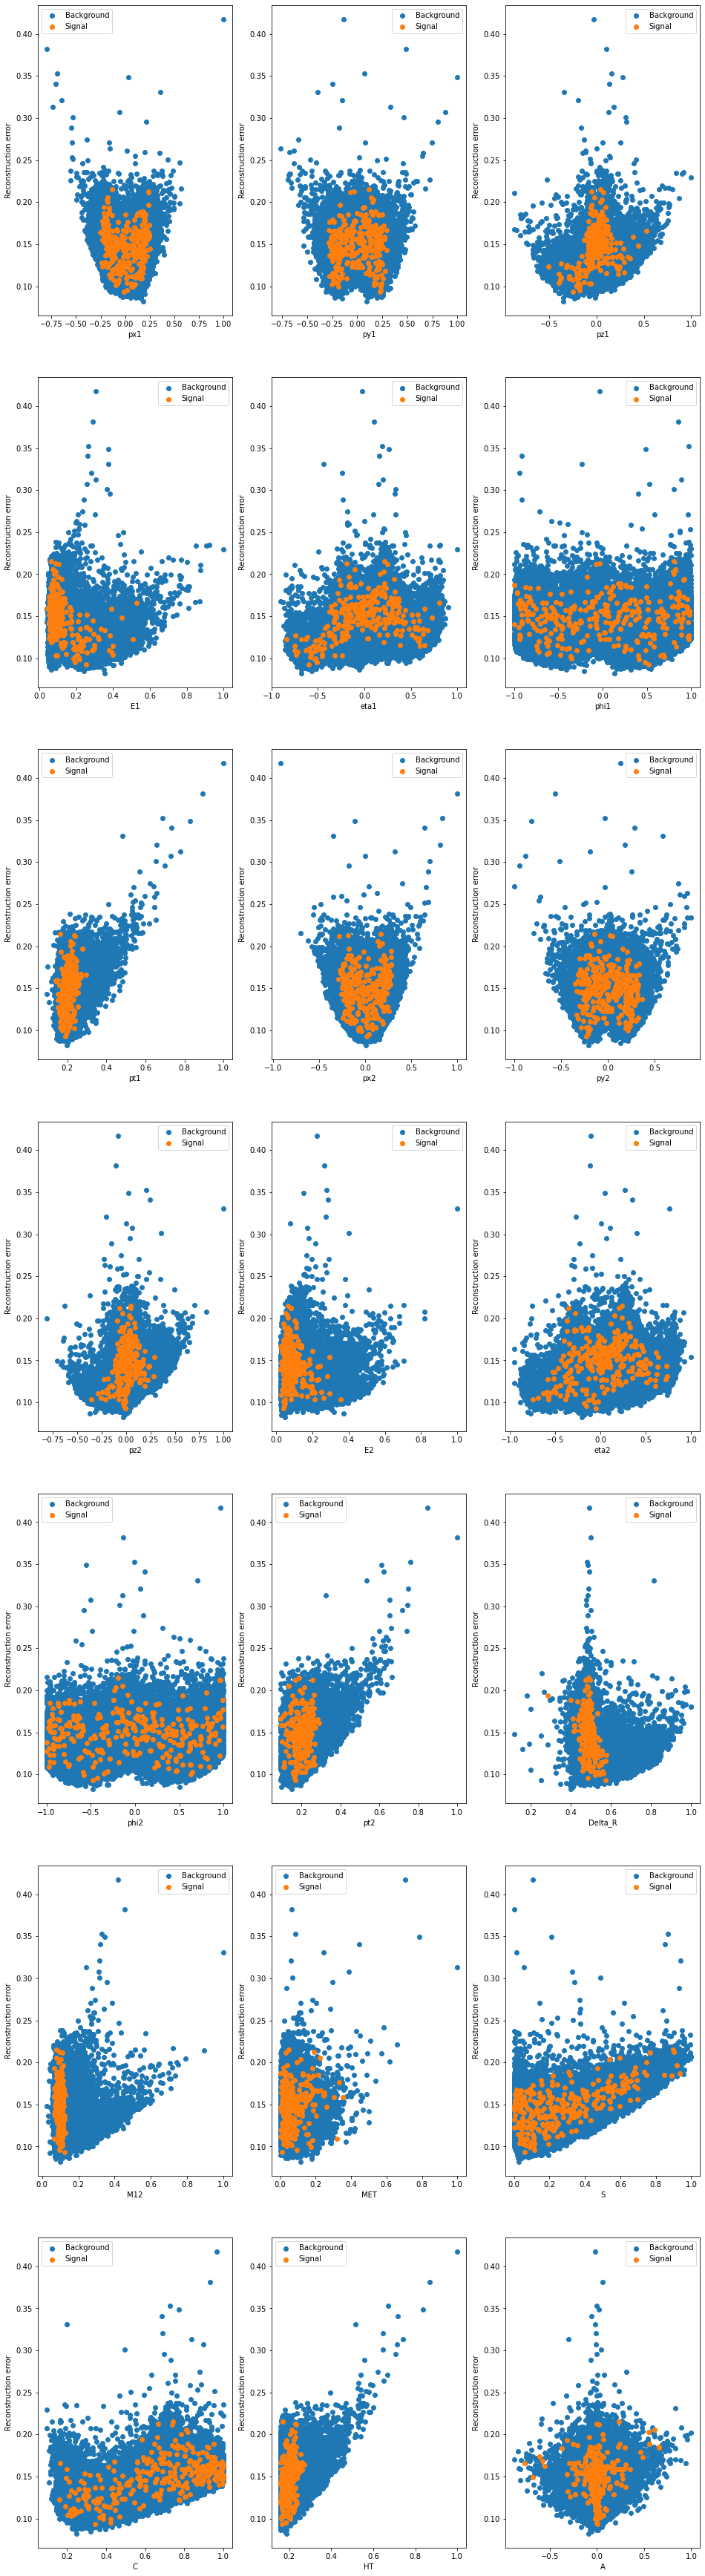

In [69]:
groups = best_model_df.groupby('class')
fig, ax = plt.subplots(7,3)
fig.set_size_inches(16,9*7)

#for i,col in enumerate(results_ditc[sort_model_names[0]]['data'].columns[:-4]):

for i,col in enumerate(best_model_df.columns[1:-3]):
    for name, group in groups:


        ax[i//3,i%3].scatter(group[col], group.reconstruction_error, 
                label= "Signal" if name == 1 else "Background")

        ax[i//3,i%3].legend()

        ax[i//3,i%3].set_ylabel("Reconstruction error")

        ax[i//3,i%3].set_xlabel(col)
        
        ax[i//3,i%3].grid()

plt.show()

# Misc

In [70]:
import time

n_elements = 1250

toolbar_width = 100


for i in range(0,n_elements+1):
    time.sleep(0.1) # do real work here
    # update the bar
    percent = i/n_elements *100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,i,n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()
    if i < (n_elements):
        sys.stdout.write("\r")  


[----------------------------------------------------------------------------------------------------] 100.00% - 1250 of 1250

In [71]:
class progress_bar:
    
    
    def __init__(self, n_elements=100,toolbar_width=50):
        
        import sys
        
        self.progress = 0
        self.n_elements = n_elements
        self.toolbar_width = toolbar_width
        print('Hello,World!')

    def begin():

        # update the bar
        percent = self.progress/n_elements *100

        info = '{:.2f}% - {:d} of {:d}'.format(percent,self.progress,self.n_elements)

        formated_bar = '-'*int(percent) + ' '*int(100-percent)

        sys.stdout.write('[%s] %s' % (formated_bar,info))
        sys.stdout.flush()
    
    def update():
        
        self.progress += 1

        # update the bar
        percent = self.progress/n_elements *100

        info = '{:.2f}% - {:d} of {:d}'.format(percent,self.progress,n_elements)

        formated_bar = '-'*int(percent) + ' '*int(100-percent)

        print('[%s] %s' % (formated_bar,info))
        sys.stdout.flush()
        
        if self.progress < (self.n_elements):
            sys.stdout.write("\r")


In [72]:
n_elements=100
bar = progress_bar(n_elements=n_elements)
bar.begin

for i in range(n_elements):
    time.sleep(0.01)
    bar.update

Hello,World!


In [73]:
from scipy import stats
rng = np.random.default_rng()

In [74]:

n1 = 200  # size of first sample
n2 = 300  # size of second sample

In [75]:
rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1, random_state=rng)
rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5, random_state=rng)
rs = stats.ks_2samp(rvs1, rvs1).pvalue

In [76]:
rs.pvalue

AttributeError: 'numpy.float64' object has no attribute 'pvalue'

In [ ]:
import tensorflow as tf
tf.map_fn(fn=lambda t: tf.range(t[:,], t + 3), elems=tf.constant([[3, 5, 2],[4,5,6]]))


InvalidArgumentError: in user code:

    /tmp/ipykernel_48531/3198347132.py:2 None  *
        lambda t: tf.range(t, t + 3), elems=tf.constant([3, 5, 2]))
    /home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1877 range
        return gen_math_ops._range(start, limit, delta, name=name)
    /home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:7192 _range
        _ops.raise_from_not_ok_status(e, name)
    /home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:6862 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    InvalidArgumentError: start must be a scalar, not shape [3] [Op:Range]


In [ ]:

You can calculate your 'values_array' by converting the "tensor-to-list" or "tensor-to-numpy". by using eval()